In [246]:
# !jupyter nbextension enable toc2/main
# !jupyter nbextension install toc2/main

In [1]:
from pathlib import Path
import pickle
import gzip
import math
import os
import time
import shutil
import struct

import torch
from torch import tensor, clamp_min
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F

# Convienience Methods & Setup

In [2]:
def relu(x): 
    return x.clamp_min(0.)

In [3]:
def lin(x, w, b):
    return x @ w + b

In [4]:
def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

In [5]:
def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()

In [6]:
def return_params():
    n = x_train.shape[0]
    nh = 50
    bs = 50
    epochs = 3
    lr = 0.1
    
    return n, nh, bs, epochs, lr

In [7]:
def test_pred_without_training(x, y, mdl=None):
    
    if mdl is None:
        mdl = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
        opt = Optimizer(mdl.parameters())
    
    preds = mdl(x)
    loss = loss_func(preds, y.long())
    return report(loss, preds, y)

In [8]:
def report(loss, preds, yb):
    print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

In [9]:
mpl.rcParams['image.cmap'] = 'gray'

# Data Preparation

In [10]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

In [11]:
from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [255]:
def load_data():
    with gzip.open(path_gz, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
        
    x_train, y_train, x_valid, y_valid = map(lambda x: torch.from_numpy(x).float(),
                                             (x_train, y_train, x_valid, y_valid))
    
    return (x_train, y_train, x_valid, y_valid)

In [53]:
x_train, y_train, x_valid, y_valid = load_data()

In [54]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((50000, 784), (50000,), (10000, 784), (10000,))

In [55]:
type(x_train)

numpy.ndarray

In [56]:
x_train[0].shape

(784,)

In [57]:
x_train.shape

(50000, 784)

In [58]:
x_train.ndim

2

In [59]:
def normalize(x, m, s):
    return (x-m)/s

In [60]:
type(x_train)

numpy.ndarray

In [61]:
train_mean = x_train.mean()
train_std = x_train.std()

The mean is not 0, the std is not 1, which makes sense, because there's no praticulat reason for it to be so,
but we do want that so we'll normalize which just means substracting the mean and dividing by standard deviation.

In [62]:
train_mean, train_std

(0.13044983, 0.3072898)

In [63]:
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

In [64]:
x_train.mean(), x_train.std()

(-3.1638146e-07, 0.99999934)

In [65]:
def test_near_zero(num: float, tol=1e-3):
    assert np.abs(num) < tol, f'Near zero {num}'

In [66]:
x_train.mean()

-3.1638146e-07

In [67]:
# passes
test_near_zero(x_train.mean())
test_near_zero(1-x_train.std())

In [68]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))

In [69]:
mpl.rcParams['image.cmap']

'gray'

In [70]:
mpl.rcParams['image.cmap'] = 'gray'

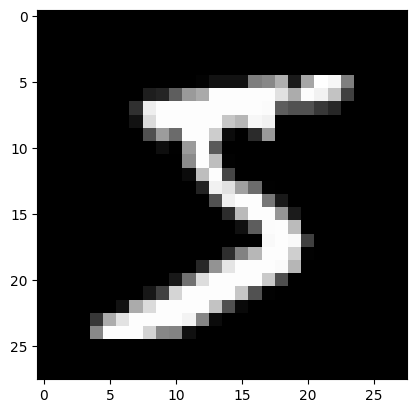

In [71]:
plt.imshow(x_train[0].reshape(28,28))

In [72]:
y_train[:3]

tensor([5, 0, 4])

In [73]:
y_train.min()

tensor(0)

In [74]:
y_train.max()

tensor(9)

initialize with random weights and bias. * we will later find out this random initializing is quite a bad idea
but more to come on that later

In [75]:
weights = torch.randn(784, 10)
bias = torch.zeros(10)

In [76]:
weights.shape, bias.shape

(torch.Size([784, 10]), torch.Size([10]))

# Matrix Multiplication

regular matrix multipication. For every row of left matrix, for every coloumn of right matrix, multiple and add
every intersection. for better visualization, see here http://matrixmultiplication.xyz/

In [86]:
def matmul_one(a,b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += a[i,k] * b[k,j]
    return c

In [87]:
# we're going to multiplie the 5 first images in validation set with the random weights we gathered
imgs = x_valid[:5]
weights = weights

In [88]:
imgs.shape, weights.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [89]:
assert imgs.shape[1] == weights.shape[0]

In [81]:
imgs.shape

torch.Size([5, 784])

In [82]:
imgs.view(5, -1).shape

torch.Size([5, 784])

- view(5, -1): This reshapes the tensor to have 5 rows and automatically calculates the second dimension (28 * 28 = 784). The -1 tells PyTorch to infer the appropriate size for that dimension.
- You can also use .reshape(5, 784) if you prefer.

In [90]:
imgs.reshape(5, 784).shape

torch.Size([5, 784])

In [91]:
imgs = imgs.view(5, -1)

In [92]:
imgs.shape

torch.Size([5, 784])

In [93]:
assert imgs.shape[1] == weights.shape[0]

In [94]:
imgs.shape, weights.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [95]:
%timeit matmul_one(imgs, weights)

372 ms ± 14.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [96]:
t1 = matmul_one(imgs, weights)

In [97]:
t1.shape

torch.Size([5, 10])

In [98]:
t1[0]

tensor([  6.8446, -34.5271,   7.5899,  -7.4181,   6.9764, -20.5725,  29.3994,
        -21.3841,  28.9898, -45.1712])

In [99]:
t1[0].max()

tensor(29.3994)

This simple matrix multiplication takes way too long. We want to do things faster, the way we would do that, is basically not use Python (as its too slow). We will write python, but the calculation will be done in C++.

The way we do this, is using PyTorch's element-wise operations which will behind the scences use the Aten C++ library. https://pytorch.org/cppdocs/. But there is some time until we get to that, lets make our way up, speeding up the process.

So this 1 line change will make things much faster. Instead of going through every intersection and adding it, we will multiple the entire column with the entire row, and only then sum it together. 

In [100]:
def matmul_two(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            # this is the only different part from our previous loop.
            # the ":" after a[i] is redundant, only here for making
            # things clearer
            c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

521 microseconds. A thousand (!) times faster.

In [101]:
%timeit -n 10 _= matmul_one(imgs, weights)

363 ms ± 1.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [102]:
%timeit -n 10 _= matmul_two(imgs, weights)

420 µs ± 24.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
411 * 1000 / 553 # 743 times faster

### Broadcasting

**broadcasting** describes how arrays with different shapes are handled during arithmetic operations.

In [103]:
a = tensor([5, -0.4, 7, -5 ])
a > 0

tensor([ True, False,  True, False])

This line above works as expected although it could seem a bit weird it does. We are checking if 0 is smaller then every one of those numbers in the a tensor, although 0 is just a scalar. The way it actually works is that 0 is being broadcasted, meaning some kind of "copied" (not really copied, memory wise) 4 times, so its actually only checking if each 0 is smaller then the respective number, we just have 4 times 0.

Its basically doing this, just not really copying, to save memory.

In [104]:
zeros = torch.zeros(4)

In [105]:
zeros

tensor([0., 0., 0., 0.])

In [108]:
a > zeros

tensor([ True, False,  True, False])

In [109]:
b = 0
a > b

tensor([ True, False,  True, False])

In [110]:
a = tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
b = tensor([1, 2, 3])

This is what basically happens, b behaves as if it was expanded to the size needed to handle a 3 size tensor. What actually happened is that 

In [111]:
c = b.expand_as(a)
c

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

In [112]:
b.shape

torch.Size([3])

In [113]:
c.shape

torch.Size([3, 3])

we see c is actually stored once, not really 3 times. So how does this work ? 

In [114]:
c.storage()

/var/folders/30/hc9ysmcs0rz72fll1lphhpp00000gp/T/ipykernel_7433/1226304414.py:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  c.storage()


 1
 2
 3
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 3]

b (here named "c"), is just doing a 0 sized move every time it moves a line, and a 1 size move every time it moves a column, so for every row, it basically just does not move

In [116]:
a = tensor([3])
# one rank tensor
a.shape

torch.Size([1])

In [118]:
a.shape

torch.Size([1])

In [120]:
a.unsqueeze(1).shape

torch.Size([1, 1])

In [121]:
a[None].shape

torch.Size([1, 1])

In [122]:
a.unsqueeze(-1).shape

torch.Size([1, 1])

In [117]:
a.unsqueeze(1).shape == a[None].shape == a.unsqueeze(-1).shape

True

So lets reduce everything to 1 loop, we only loop through the rows in the left matrix and say: broadcast the first row in a to a 2 rank tensor so it can be multiplied with b and then sum everything on the first axis. Do this for every row in a. 

In [136]:
imgs.unsqueeze(-1).shape

torch.Size([5, 784, 1])

In [137]:
weights.shape

torch.Size([784, 10])

## Matmul Using Broadcasting

In [186]:
def matmul_three(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
#         c[i] = (a[i].unsqueeze(-1) * b).sum(dim=0) # this line and the next are the same
        c[i] = (a[i, :, None] * b).sum(dim=0) # take every row, all its columns and create another axis. This 
    # additional axis will be broadcasted to the size of b. This allows us to get rid of looping through b
    return c

In [187]:
%timeit -n 10 _= matmul_three(imgs, weights)

298 µs ± 152 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [188]:
%timeit -n 10 _= matmul_one(imgs, weights)

367 ms ± 5.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [157]:
411 * 1000 / 258

1593.0232558139535

Lastly, we will use the PyTorch function matmul (also works as @) which is by far the fastest. PyTorch uses a totally different way calculation. While Python has to use RAM memory again and again, PyTorch splits the calculation into separate parts and so is able to do things faster. *Pytorch doesn't really do it itself, it actually uses a linear algerbra library named BLAS (some companies like Intel, Nvidia etc have their own implementations for that). Bottom line - it works way faster. The down side is of course, we lose quite a lot of flexibility

Didnt we just say PyTorch is using a package called Aten?

ATen is the core library for PyTorch's tensor operations.
For linear algebra and other optimized operations, PyTorch can use BLAS on CPU (MKL, OpenBLAS, etc.) and cuBLAS on GPU.

In [189]:
imgs.shape, weights.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [191]:
%timeit -n 10 imgs @ weights

The slowest run took 7.88 times longer than the fastest. This could mean that an intermediate result is being cached.
27.4 µs ± 27.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit -n 10 matmul_one(imgs, weights)

Twenty five thousand (!!!) times faster.

In [ ]:
370 * 1000 / 15

# Normalization

## Random Weights Initialization

Start with fresh, unmanipulated data

In [313]:
x_train, y_train, x_valid, y_valid = load_data()

In [314]:
def normalize(x, mean, std):
    return (x - mean) / std

In [315]:
type(x_train)

torch.Tensor

In [312]:
train_mean = x_train.mean()
train_std = x_train.std()

The mean is not 1, the std is not 1, which makes sense, because there's no particular reason for it to be so,
but we do want that  cause it works less good, so we'll normalize which just means subtracting the mean and dividing by standard deviation.

In [279]:
train_mean, train_std

(tensor(0.1304), tensor(0.3073))

In [280]:
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

In [281]:
x_train.mean(), x_train.std()

(tensor(2.1325e-08), tensor(1.))

In [282]:
train_mean = x_train.mean()
train_std = x_train.std()

In [283]:
def test_near_zero(num: float, tol=1e-3):
    assert np.abs(num) < tol, f'Near zero {num}'

In [284]:
# passes
test_near_zero(x_train.mean())
test_near_zero(1-x_train.std())

So the problem is this: we want the inputs to any layer to be with a mean o 0 and std of 1. On the first layer, mission accomplished, we have it. Problem is .. if we initialize the weights randomly, the input to the second layer, won't be like this anymore. Lets see this

In [316]:
# number of hidden parameters
nh = 50

In [317]:
x_train.shape

torch.Size([50000, 784])

In [320]:
w1 = torch.randn(28*28, nh)
b1 = torch.randn(nh)

In [321]:
w1.shape, b1.shape

(torch.Size([784, 50]), torch.Size([50]))

In [322]:
x_valid.shape

torch.Size([10000, 784])

In [323]:
def lin(x, w, b):
    return x @ w + b

In [324]:
r1 = lin(x_valid, w1, b1)

In [325]:
type(x_valid), type(w1), type(b1)

(torch.Tensor, torch.Tensor, torch.Tensor)

In [326]:
x_valid.dtype, w1.dtype, b1.dtype

(torch.float32, torch.float32, torch.float32)

In [327]:
r1.shape

torch.Size([10000, 50])

In [328]:
r1.mean(), r1.std()

(tensor(-0.1188), tensor(8.7247))

## Kaming He Weights Initialization

In [329]:
x_train, y_train, x_valid, y_valid = load_data()

In [330]:
train_mean = x_train.mean()
train_std = x_train.std()

In [331]:
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

In [332]:
x_train.mean(), x_train.std()

(tensor(2.1325e-08), tensor(1.))

In [333]:
weights = torch.randn(784, 10)
imgs = x_valid[:5]

In [334]:
m = 784
nh = 50

Without normalizing the weights, after one linear process, the result will no longer be normalized

In [335]:
w1 = torch.randn(m, nh)
b1 = torch.zeros(nh)
w2 = torch.randn(nh, 1)
b2 = torch.zeros(1)

In [336]:
r2 = lin(x_valid, w1, b1)

In [337]:
r2.mean(), r2.std()

(tensor(0.6894), tensor(29.0576))

In [338]:
w1 = torch.randn(m, nh)/math.sqrt(m)
b1 = torch.zeros(nh)
w2 = torch.randn(nh, 1)/math.sqrt(nh)
b2 = torch.zeros(1)

Now, they ARE normalized

In [339]:
r2 = lin(x_valid, w1, b1)
r2.mean(), r2.std()

(tensor(-0.0009), tensor(0.9586))

# Activation Functions - See Separate Notebook

ReLU is very simple. Take any negative value, replace it with zero. Take any positive value, keep it as it was.

In [17]:
def relu(x): 
    return x.clamp_min(0.)

In [18]:
negative_tensor = torch.tensor(-3)
negative_tensor

tensor(-3)

In [19]:
positive_tensor = torch.tensor(3)
positive_tensor

tensor(3)

In [20]:
relu(negative_tensor)

tensor(0.)

In [21]:
relu(positive_tensor)

tensor(3.)

In [22]:
t = relu(lin(x_valid, w1, b1))

Once again, not normalized.

In [23]:
t.mean(), t.std()

(tensor(0.4322), tensor(0.6080))

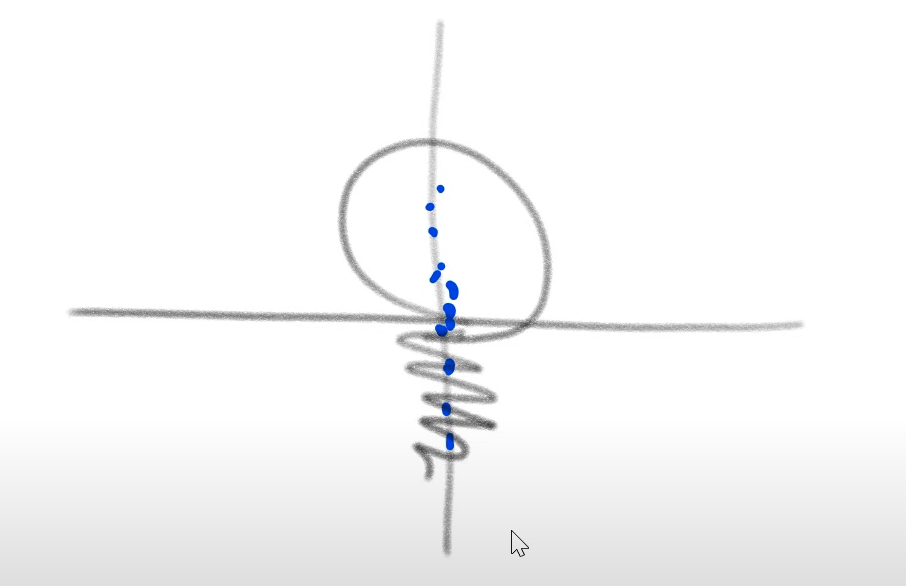

# Kaiming he initialization

In [15]:
def he_initialization(n_in, n_out):

    # Standard deviation for He initialization
    stddev = np.sqrt(2 / n_in)
    
    # Random normal distribution with mean 0 and standard deviation calculated above
    weights = torch.randn(n_in, n_out) * stddev
    
    return weights

In [16]:
def return_processed_data():
    
    x_train, y_train, x_valid, y_valid = load_data()
    x_train, y_train, x_valid, y_valid = map(lambda x: torch.from_numpy(x).float(),
                                             (x_train, y_train, x_valid, y_valid))
    x_valid = x_valid.view(10000, 28*28)
    x_train = x_train.view(60000, 28*28)
    
    x_train_mean = x_train.mean()
    x_train_std = x_train.std()
    
    x_train = normalize(x_train, x_train_mean, x_train_std)
    x_valid = normalize(x_valid, x_train_mean, x_train_std)
    
    return x_train, y_train, x_valid, y_valid

In [17]:
x_train, y_train, x_valid, y_valid = return_processed_data()

In [18]:
m = 784
nh = 50

In [19]:
random_w1 = torch.randn(m, nh)
random_w2 = torch.randn(nh, 1)

In [20]:
random_w1.mean(), random_w1.std()

(tensor(0.0014), tensor(1.0018))

In [21]:
b1 = torch.zeros(nh)

In [22]:
t = relu(lin(x_valid, random_w1, b1))

In [23]:
t.mean(), t.std()

(tensor(11.6536), tensor(17.3166))

In [24]:
w1 = he_initialization(m, nh)
b1 = torch.zeros(nh)
w2 = he_initialization(nh, 1)
b2 = torch.zeros(1)

In [25]:
t = relu(lin(x_valid, w1, b1))

So much better

In [26]:
t.mean(), t.std()

(tensor(0.5989), tensor(0.8472))

In [49]:
x_valid.shape

torch.Size([10000, 784])

In [50]:
w1.shape

torch.Size([784, 50])

In [51]:
t = relu(lin(x_valid, w1, b1))

Not perfectly normalized, but better than before.

In [52]:
t.mean().item(), t.std().item()

(0.521189272403717, 0.8180544376373291)

In [53]:
from torch.nn import init

In [54]:
def pytorch_he_initialization(weights):
    
    return init.kaiming_normal_(weights, mode='fan_out')
    

In [55]:
he_w1 = torch.zeros(m, nh)

In [56]:
he_w1

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [57]:
better_weights = pytorch_he_initialization(w1)

In [58]:
better_weights.mean(), normalized_weights.std()

NameError: name 'normalized_weights' is not defined

In [59]:
t = relu(lin(x_valid, he_w1, b1))

In [60]:
t.mean(), t.std()

(tensor(0.), tensor(0.))

# Forward Pass

Forward pass is where we calculate the loss

In [61]:
def model(xb):
    l1 = lin(xb, w1, b1)
    l2 = relu(l1)
    l3 = lin(l2, w2, b2)
    return l3

In [62]:
%timeit -n 10 _ = model(x_valid)

The slowest run took 4.71 times longer than the fastest. This could mean that an intermediate result is being cached.
2.55 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


01:46:15

# Loss Function

In [63]:
model(x_valid).shape

torch.Size([10000, 1])

In [64]:
def mse(output, targs):
    
    return (output.squeeze(-1) - targs).pow(2).mean()

In [65]:
preds = model(x_valid)

In [66]:
preds.shape

torch.Size([10000, 1])

In [67]:
mse(preds, y_valid)

tensor(30.3195)

In [68]:
x_valid.shape, x_train.shape

(torch.Size([10000, 784]), torch.Size([60000, 784]))

# Backward Pass

### Short ByPass to Understand Debugger

In [69]:
import pdb

In [70]:
def weird_func(a,b):
    
    first_step = a + b
    second_step = a / b
    
    pdb.set_trace()
    
    third_step = a * b
    return third_step

In [71]:
# weird_func(1,2)

## Chain Rule

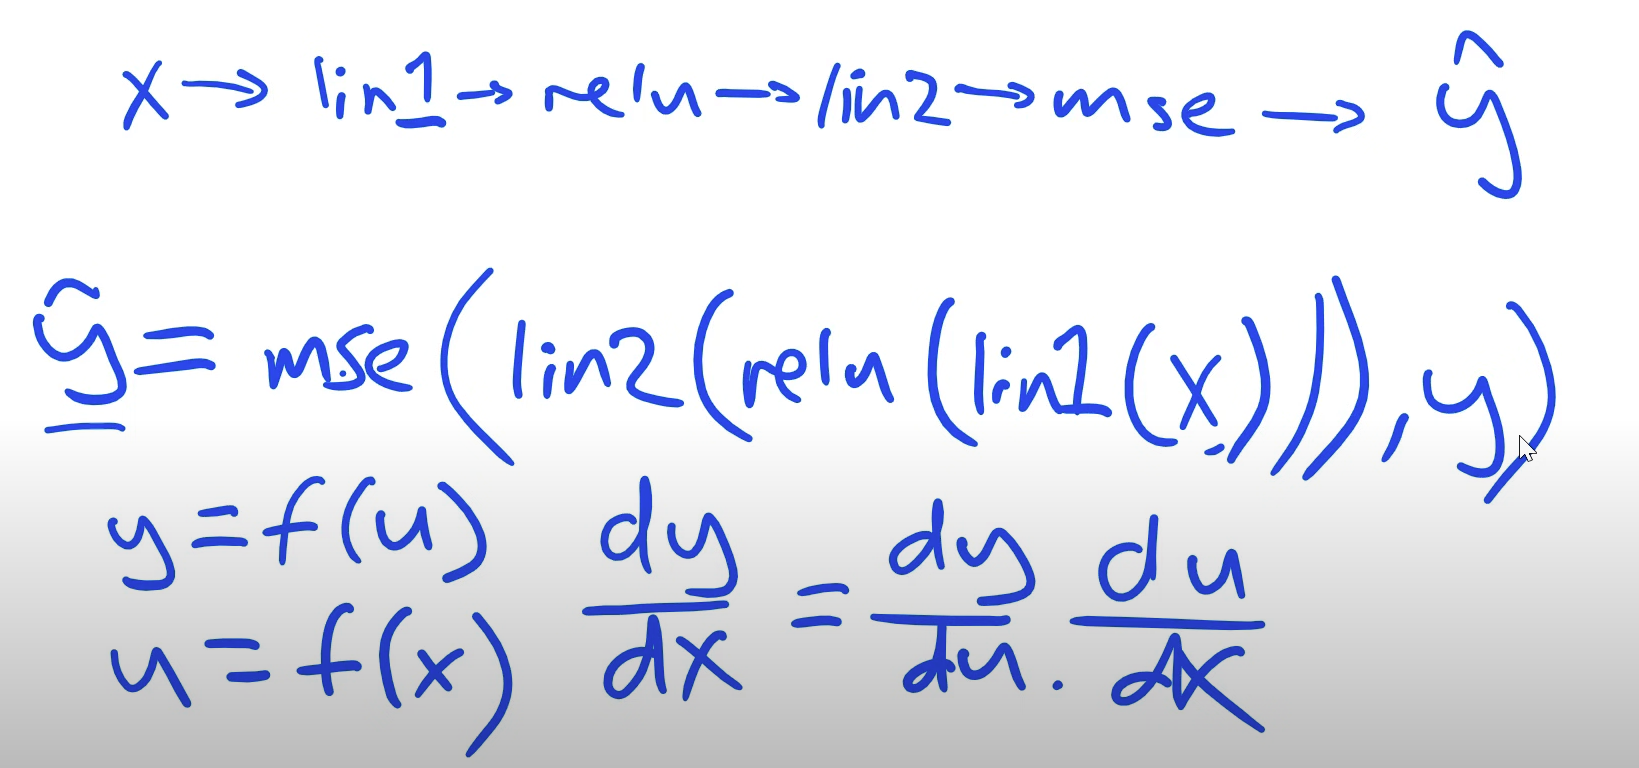

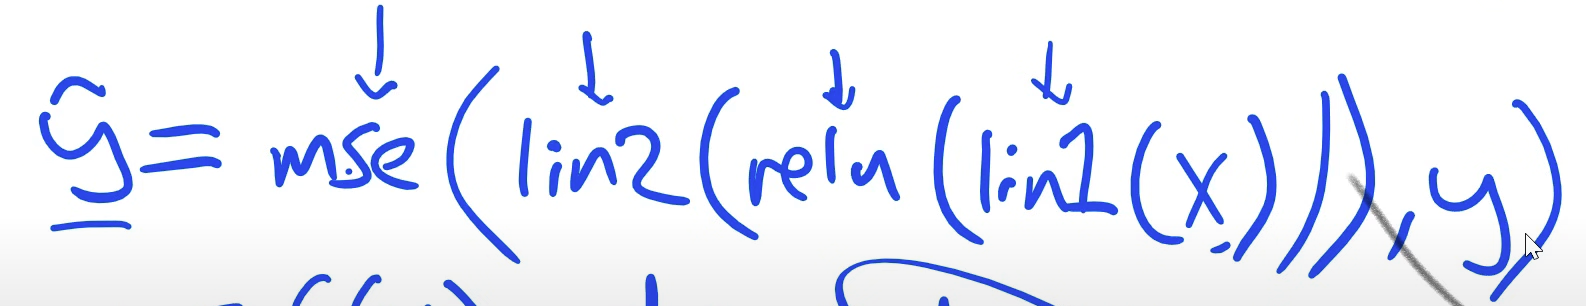

In [72]:
def mse_grad(inp, targ):
    # gradient of the loss with respect to the output of the previous layer
    # we divide by inp.shape[0] to get the mean (becasue MSE was originally calculated on the mean)
    
    inp.gradient = 2. * (inp.squeeze() - targ).unsqueeze(-1) / inp.shape[0]

In [73]:
def relu_grad(inp, out):
    # gradient of relu multiplied by the gradient of the next layer
    inp.gradient = (inp > 0).float() * out.gradient

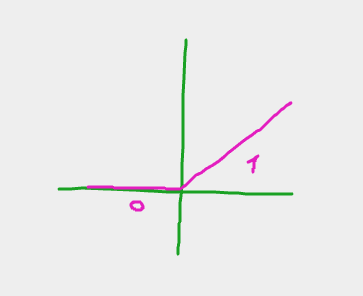

In [74]:
def lin_grad(inp, out, w, b):
    
    # the gradient of a matrix product, is the matrix product with a transpose
    inp.gradient = out.gradient @ w.t()
        
    w.gradient = (inp.unsqueeze(-1) * out.gradient.unsqueeze(1)).sum(0)

    b.gradient  = out.gradient.sum(0)

In [75]:
def forward_and_backward(inp, target):
    
    # forward pass
    l1 = inp @ w1 + b1
    l2 = relu(l1)
    out = l2 @ w2 + b2
    
    # not needed for the backward pass
    loss = mse(out, target)
    
    # backward pass goes in the reverse direction
    mse_grad(out, target)
    lin_grad(l2, out, w2, b2)
    relu_grad(l1, l2)    
    lin_grad(inp, l1, w1, b1)

In [76]:
forward_and_backward(x_train, y_train)

In [77]:
w1g = w1.gradient.clone()
w2g = w2.gradient.clone()
b1g = b1.gradient.clone()
b2g = b2.gradient.clone()
inp_g = x_train.gradient.clone()

In [78]:
xt2 = x_train.clone().requires_grad_(True)
w12 = w1.clone().requires_grad_(True)
w22 = w2.clone().requires_grad_(True)
b12 = b1.clone().requires_grad_(True)
b22 = b2.clone().requires_grad_(True)

In [79]:
def forward(inp, targ):
    
    l1 = inp @ w12 + b12
    l2 = relu(l1)
    out = l2 @ w22 + b22
    
    return mse(out, targ)

In [80]:
loss = forward(xt2, y_train)

In [81]:
loss.backward()

In [82]:
def test(a, b, cmp, cname=None):
    if cname is None:
        cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}\n{'problem is with these two above'}"

def test_eq(a,b):
    test(a, b, operator.eq, '==')

In [83]:
def near(a, b):
    return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
    
def test_near(a, b):
    return test(a, b, near)

In [84]:
# PyTorch stores gradients in .grad, not .gradient like we did here
test_near(w22.grad, w2g)
test_near(b22.grad, b2g)
test_near(w12.grad, w1g)
test_near(b12.grad, b1g)
test_near(xt2.grad, inp_g)

# Refactor

In [85]:
class Relu():
    
    def __call__(self, inp):
        self.inp = inp
        self.out = inp.clamp_min(0.)
        return self.out
    
    def backward(self):
        # gradient will now be g, for convenience
        self.inp.g = (self.inp>0).float() * self.out.g

In [86]:
class Lin():
    
    def __init__(self, w, b):
        self.w = w
        self.b = b
        
    def __call__(self, inp):
        self.inp = inp
        self.out = inp @ self.w + self.b
        return self.out
    
    def backward(self):
        self.inp.g = self.out.g @ self.w.t()
        self.w.g = (self.inp.unsqueeze(-1) * self.out.g.unsqueeze(1)).sum(0)
        self.b.g = self.out.g.sum(0)

In [87]:
class Mse():
    
    def __call__(self, inp, targ):
        self.inp = inp
        self.targ = targ
        self.out = (inp.squeeze() - targ).pow(2).mean()
        
    def backward(self):
        self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.targ.shape[0]

In [88]:
class Model():
    
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1, b1), Relu(), Lin(w2, b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for layer in self.layers:
            x = layer(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for layer in reversed(self.layers):
            layer.backward()
        

In [89]:
w1.g, b1.g, w2.g, b2.g = [None] * 4

In [90]:
w1.g, b1.g, w2.g, b2.g

(None, None, None, None)

In [91]:
model = Model(w1, b1, w2, b2)

In [92]:
loss = model(x_train, y_train)

In [93]:
model.backward()

In [94]:
test_near(w22.grad, w2.g)
test_near(b22.grad, b2.g)
test_near(w12.grad, w1.g)
test_near(b12.grad, b1.g)
test_near(xt2.grad,x_train.g)

## Refactor2

In [95]:
class Module():
    
    def __call__(self, *args):            
        # now we dont need to call self.inp and return self.out on every class
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def forward(self):
        raise Exception('not implemented')
        
    def backward(self):
        self.bwd(self.out, *self.args)

In [96]:
class Relu(Module):
    
    def forward(self, inp):
        return inp.clamp_min(0.)
    
    def bwd(self, out, inp):
        inp.g = (inp>0).float() * out.g

In [97]:
class Lin(Module):
    def __init__(self, w, b):
        self.w = w
        self.b = b
    
    def forward(self, inp): return inp @ self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = inp.t() @ out.g
        self.b.g = out.g.sum(0)
    

In [98]:
class Mse(Module):
    
    def forward (self, inp, targ):
        self.diff = inp.squeeze() - targ
        return self.diff.pow(2).mean()
    
    def bwd(self, out, inp, targ):
        inp.g = 2 * self.diff.unsqueeze(-1) / targ.shape[0]

In [99]:
class Model():
    def __init__(self):
        self.layers = [Lin(w1, b1), Relu(), Lin(w2, b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers:
            x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers):
            l.backward()

In [100]:
w1.g, b1.g, w2.g, b2.g = [None] * 4
model = Model()

In [101]:
model(x_train, y_train)

tensor(30.5407)

In [102]:
model.backward()

In [103]:
test_near(w22.grad, w2.g)
test_near(b22.grad, b2.g)
test_near(w12.grad, w1.g)
test_near(b12.grad, b1.g)
test_near(xt2.grad,x_train.g)

## PyTorch Equivalent 

### Autograd

In [104]:
from torch import nn
import torch.nn.functional as F

In [105]:
class Linear(nn.Module):
    
    def __init__(self, n_in, n_out):
        super().__init__()
        self.w = torch.randn(n_in, n_out).requires_grad_()
        self.b = torch.zeros(n_out).requires_grad_()
        
    def forward(self, inp):
        return inp @ self.w + self.b

In [106]:
class Model(nn.Module):
    
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.layers = [Linear(n_in, n_hidden), nn.ReLU(), Linear(n_hidden, n_out)]
        self.loss = mse
        
    def __call__(self, x, targ):
        for l in self.layers:
            x = l(x)
        return F.mse_loss(x, targ[:, None])

In [107]:
model = Model(m, nh, 1)

In [108]:
loss = model(x_train, y_train)

In [109]:
loss.backward()

In [113]:
model.layers

[Linear(), ReLU(), Linear()]

In [120]:
lin_layer = model.layers[0]

In [121]:
lin_layer

Linear()

In [125]:
lin_layer.b.grad

tensor([ -51.5854,   36.9356,  -24.3753,   80.6037,   -5.9091,   18.7711,
         -25.6816,    5.7068,   10.4405,  -19.3020, -135.4201,   21.9693,
         214.5061,  -11.4347, -105.2996,   31.6981,   21.3388,  201.6037,
         203.4274,  123.9780,  168.3987,   79.3477,    4.1180,   21.0176,
          39.5637,  213.5186,  -21.1989,   -7.3791,   30.1914,  -18.2387,
        -256.2716,  -56.3965,  -99.5888,   27.2262,  134.6343,  137.3997,
          -0.6095, -140.2997,  240.7109,  -53.5373,  -75.0386,  -21.8871,
          -5.8767,   60.0481,   81.0168,  -74.0352,   44.2350,  -50.7088,
        -134.1630,  173.5174])

In [127]:
lin_layer.w.grad.shape

torch.Size([784, 50])

# Better Loss Function

## Optimization Break

In [110]:
# %pip install numba

In [186]:
def loop(a):
    for i in range(a):
        calc =  a**2 / 0.65

In [191]:
%timeit -n 10 loop(10_000_000)

560 ms ± 7.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [192]:
from numba import njit

In [193]:
@njit
def loop2(a):
    for i in range(a):
        calc =  a**2 / 0.65

In [194]:
%time loop2(10_000_000)

CPU times: user 20.9 ms, sys: 1.44 ms, total: 22.3 ms
Wall time: 21.2 ms


In [210]:
%timeit -n 10_000 loop2(10_000_000)

206 ns ± 26.8 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [211]:
%timeit -n 10_000 loop2(10_000_000)

196 ns ± 126 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Back To the Loss

Lets start with a reasonable loss function - see notebook about loss functions

In [128]:
def log_softmax():
    return (x.exp() / (x.exp().sum(-1, keepdim=True))).log()

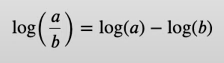

In [130]:
def simplified_log_softmax(x):
    
    return x - x.exp().sum(-1, keepdim=True).log()

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [131]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

In [132]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [135]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [137]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [140]:
model = Model(m, nh, 10)
pred = model(x_train)
pred

tensor([[ 0.0245,  0.0211,  0.0925,  ..., -0.0971,  0.0360,  0.0191],
        [ 0.2069,  0.4662,  0.0802,  ..., -0.2080, -0.0929,  0.0031],
        [-0.0123, -0.0229, -0.0333,  ...,  0.1973, -0.0056,  0.1349],
        ...,
        [-0.1712,  0.0550,  0.1030,  ...,  0.0133,  0.0785, -0.0131],
        [-0.0438, -0.2130, -0.0127,  ..., -0.0756,  0.2058,  0.2121],
        [-0.1092,  0.0968,  0.1074,  ..., -0.1345,  0.2023,  0.1718]],
       grad_fn=<AddmmBackward0>)

In [141]:
pred.shape

torch.Size([60000, 10])

In [144]:
pred[0]

tensor([ 0.0245,  0.0211,  0.0925, -0.0287,  0.0240,  0.1620,  0.0129, -0.0971,
         0.0360,  0.0191], grad_fn=<SelectBackward0>)

In [153]:
loss_func = F.cross_entropy(pred, y_train)

RuntimeError: expected scalar type Long but found Float

In [161]:
loss = F.cross_entropy(pred, y_train.long())

In [162]:
loss

tensor(2.3081, grad_fn=<NllLossBackward0>)

# Training 

In [163]:
loss_func = F.cross_entropy

In [164]:
bs = 64
xb = x_train[0:bs]
preds = model(xb)

In [165]:
preds.shape

torch.Size([64, 10])

In [166]:
preds[0]

tensor([ 0.0245,  0.0211,  0.0925, -0.0287,  0.0240,  0.1620,  0.0129, -0.0971,
         0.0360,  0.0191], grad_fn=<SelectBackward0>)

In [168]:
yb = y_train[0:bs]
loss_func(preds, yb.long())

tensor(2.3305, grad_fn=<NllLossBackward0>)

In [172]:
preds.argmax(dim=1)

tensor([5, 1, 7, 3, 3, 5, 7, 9, 5, 9, 3, 5, 5, 3, 5, 0, 7, 8, 3, 6, 9, 1, 9, 3,
        4, 3, 3, 5, 7, 9, 5, 9, 9, 6, 9, 8, 3, 9, 7, 3, 3, 0, 5, 6, 5, 5, 5, 8,
        5, 1, 3, 1, 3, 9, 9, 3, 1, 6, 5, 3, 9, 9, 3, 1])

In [170]:
preds[0]

tensor([ 0.0245,  0.0211,  0.0925, -0.0287,  0.0240,  0.1620,  0.0129, -0.0971,
         0.0360,  0.0191], grad_fn=<SelectBackward0>)

In [173]:
accuracy(preds, yb)

tensor(0.1250)

## Train Loop

Training loop algorithm:

- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [288]:
lr = 0.1
epochs = 2

In [49]:
loss_func = F.cross_entropy

In [291]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb = x_train[s]
        yb = y_train[s].long()
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        
        if i % 100 == 0:
            print(loss.item())
        
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()                    

81.23048400878906
827.1973876953125
349.2830810546875
2416.7958984375
229.3559112548828
162.68124389648438
53.75467300415039
397.4322509765625
1630.4775390625
77.20608520507812
83.61849212646484
490.5135192871094
282.0800476074219
445.0279235839844
32.253273010253906
37.12781524658203
98.09285736083984
39.99154281616211
122.55679321289062
248.26983642578125
285.6798400878906
33.36044692993164
111.2326431274414
146.245361328125
158.6802978515625
109.7429428100586
71.53024291992188
179.13075256347656
107.08207702636719
1257.892578125
186.87400817871094
194.86705017089844
146.38070678710938
285.7792663574219
85.86540222167969
767.5579223632812
282.712646484375
348.4291076660156
255.873779296875
344.2520751953125
197.60528564453125
1160.688232421875
136.61488342285156
79.40541076660156
26.6479549407959
457.7134704589844
991.467041015625
32.663055419921875
31.51165771484375
311.36712646484375
195.22238159179688
376.5226745605469
36.37407684326172
29.792028427124023
182.52218627929688
27.911

In [292]:
accuracy(preds, yb).item()

0.59375

In [293]:
preds[0].argmax(), yb[0]

(tensor(8), tensor(5))

In [294]:
preds[1].argmax(), yb[1]

(tensor(8), tensor(9))

In [295]:
preds[0]

tensor([-60.1451,  49.0302, -69.1703, -16.9609,  44.9965, -81.2041, -15.9987,
         49.3744,  49.9450,  49.9173], grad_fn=<SelectBackward0>)

## Refactor Training

In [104]:
x_train, y_train, x_valid, y_valid = return_processed_data()

In [105]:
n, nh, bs, epochs, lr = return_params()

In [106]:
model = MLP(m, nh, 10)

Initially, the results dont look good.

In [107]:
xb = x_train[:bs]
yb = y_train[:bs].long()

preds = model(xb)

report(loss_func(preds, yb), preds, yb)

2.33, 0.08


After training, it gets much better

In [108]:
x_train, y_train, x_valid, y_valid = return_processed_data()

In [109]:
prediction = model(x_train[0])
prediction.argmax(0)

tensor(1)

In [ ]:
plt.imshow(x_train[0].reshape(28, 28))

In [112]:
prediction = model(x_train[1])
prediction.argmax(0)

tensor(1)

In [113]:
y_train[1]

tensor(0.)

In [87]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(n,i+bs))
            xb,yb = x_train[s],y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb.long())
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
        report(loss, preds, yb)

In [88]:
fit()

0.05, 0.98
0.02, 1.00
0.01, 1.00


In [90]:
y_train[0]

tensor(5.)

In [97]:
prediction = model(x_train[0])
prediction.argmax(0)

tensor(5)

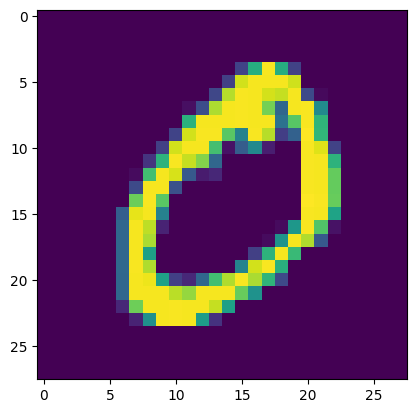

In [100]:
plt.imshow(x_train[1].reshape(28, 28))

In [101]:
y_train[1]

tensor(0.)

In [103]:
prediction = model(x_train[1])
prediction.argmax(0)

tensor(0)

How did the MLP know how to find the layers and parameters? It knew it because its inherits from nn.module. So what does this nn.module thing do? Well, many things, but specifically to its awareness of layers and parameters, it does this:

In [152]:
class MyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)

    def __setattr__(self,k,v):
        if not k.startswith("_"):
            self._modules[k] = v
        super().__setattr__(k,v)

In [165]:
t = MyModule(m, nh, 10)

In [166]:
t._modules

{'l1': Linear(in_features=784, out_features=50, bias=True),
 'l2': Linear(in_features=50, out_features=10, bias=True)}

Whats going on in here? whats this __setattr__ thing? How does it work?

In [240]:
class SetAttrExample:
    
    def __init__(self, c=100):
        self. a = c
        
    def __setattr__(self, a, _):
        print('__setattr__ has been activated because of the init function')
        super().__setattr__(a, _)


In [243]:
a = SetAttrExample()

__setattr__ has been activated because of the init function


In [244]:
a.a

100

In [250]:
class MyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)

    def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)

    def __repr__(self):
        print('__repr__ is called')
        return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values(): yield from l.parameters()

In [251]:
mdl = MyModule(m, nh, 10)

In [252]:
mdl

__repr__ is called


{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [254]:
for param in mdl.parameters():
    print(p.shape)

torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])


## nn.Module

In [230]:
m1 = nn.Module()
m1.foo = nn.Linear(3,4)
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [ ]:
m1.named_children()

In [231]:
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [233]:
list(m1.parameters())

[Parameter containing:
 tensor([[-0.3282,  0.1434,  0.5248],
         [-0.1250, -0.0103, -0.2279],
         [ 0.2582,  0.4748, -0.3507],
         [-0.1914, -0.3262, -0.5486]], requires_grad=True),
 Parameter containing:
 tensor([-0.0145, -0.0307,  0.1947, -0.5466], requires_grad=True)]

In [34]:
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        self.relu = nn.ReLU()
        
    def forward(self, x): return self.l2(self.relu(self.l1(x)))

In [35]:
model = MLP(m, nh, 10)
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [36]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [37]:
for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [38]:
for p in model.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [255]:
from functools import reduce

In [256]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [257]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers):
            # add_module --> PyTorch method
            self.add_module(f'layer_{i}', l)
            
    def forward(self, x):
        return reduce(lambda val, layers: later(val), self.layers, x)

In [270]:
model = Model(layers)

In [271]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

PyTorch version

In [272]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [273]:
fit()

0.03, 1.00
0.01, 1.00
0.01, 1.00


This is our previous train loop. Lets simplify it further

In [277]:
# def fit():
#     for epoch in range(epochs):
#         for i in range(0, n, bs):
#             s = slice(i, min(n,i+bs))
#             xb,yb = x_train[s],y_train[s]
#             preds = model(xb)
#             loss = loss_func(preds, yb.long())
#             loss.backward()
#             with torch.no_grad():
#                 for p in model.parameters():
#                     p -= p.grad * lr
#                 model.zero_grad()
#         report(loss, preds, yb)

### Optimizer

In [280]:
class Optimizer:
    
    def __init__(self, params, lr=0.1):
        self.params = list(params)
        self.lr = lr
    
    def step(self):
        with torch.no_grad():
            for p in self.params:
                p -= p.grad * self.lr
                
    def zero_grad(self):
        for p in self.params:
            # using .data lets us avoide using torch.no_grad()
            p.grad.data.zero_()

In [295]:
mdl = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

This is a generator, thats why we needed to turn params into a list in the Optimizer init func

In [296]:
mdl.parameters()

<generator object Module.parameters at 0x156816f80>

In [297]:
opt = Optimizer(mdl.parameters())

In [306]:
x_train, y_train, x_valid, y_valid = return_processed_data()

In [315]:
if 'mdl' in globals():
    del mdl

In [323]:
mdl = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
opt = Optimizer(mdl.parameters())

Before training

In [324]:
test_pred_without_training(x_train[:100], y_train[:100])

2.35, 0.07


After training

In [325]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, i+bs))
        xb,yb = x_train[s], y_train[s]
        preds = mdl(xb)
        loss = loss_func(preds, yb.long())
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.03, 1.00
0.01, 1.00
0.01, 1.00


In [326]:
from torch import optim

In [327]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [328]:
mdl, opt = get_model()

2.4 loss

In [330]:
loss_func(mdl(xb), yb.long())

tensor(2.4039, grad_fn=<NllLossBackward0>)

In [334]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb = x_train[s]
        yb = y_train[s]
        preds = mdl(xb)
        loss = loss_func(preds, yb.long())
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.03, 1.00
0.01, 1.00
0.01, 1.00


Almost 0 loss

In [335]:
loss_func(mdl(xb), yb.long())

tensor(0.0051, grad_fn=<NllLossBackward0>)

Everything in our previous train loop looks reasonably reasonable. Except for the slice thing, and having to create x_train and y_train separately. Lets fix this

# Dataset & DataLoader

## Dataset

Instead of writing 

        xb = x_train[s]
        yb = y_train[s]

I want this

```python
    xb,yb = train_ds[s]
```

In [337]:
class Dataset:
    
    def __init__(self, x, y):
        self.x = x
        self.y = y.long() # PyTorch cross entropy loss expects this to be a long tensor
        
    def __len__(self):
        return len(self.x)
        
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [338]:
train_ds = Dataset(x_train, y_train)
valid_ds = Dataset(x_valid, y_valid)

In [339]:
x_train.dtype, y_train.dtype, x_valid.dtype, y_valid.dtype

(torch.float32, torch.float32, torch.float32, torch.float32)

In [340]:
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [341]:
xb, yb = train_ds[0:5]

In [342]:
xb.shape

torch.Size([5, 784])

In [343]:
yb.shape

torch.Size([5])

In [346]:
mdl, opt = get_model()

In [347]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        xb,yb = train_ds[i:min(n,i+bs)]
        preds = mdl(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.04, 1.00
0.01, 1.00
0.01, 1.00


## DataLoader

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range(0, n, bs):
    xb,yb = train_ds[i:min(n,i+bs)]
    ...
```

Let's make our loop much cleaner, using a data loader:

```python
for xb,yb in train_dl:
    ...
```

In [364]:
class DataLoader:
    
    def __init__(self, ds, bs):
        self.ds = ds
        self.bs = bs
        
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i:i+self.bs]

In [374]:
class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [375]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [424]:
first_bs = iter(train_dl)

In [427]:
xb, yb = next(first_bs)

In [428]:
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

In [429]:
xb[0].shape

torch.Size([784])

In [430]:
xb[0][:10]

tensor([-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
        -0.4241, -0.4241])

In [431]:
yb[:5]

tensor([4, 6, 1, 9, 9])

The next batch, will be different numbers. Same size, different numbers

In [432]:
second_bs = next(first_bs)

In [433]:
yb[:5]

tensor([4, 6, 1, 9, 9])

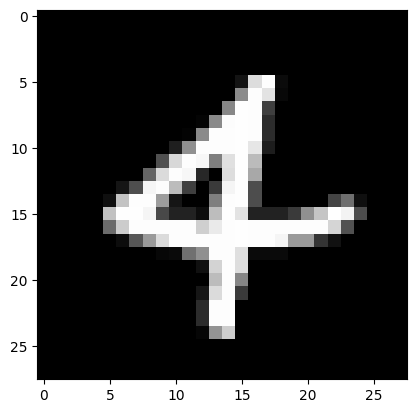

In [434]:
plt.imshow(xb[0].view(28,28))

In [435]:
mdl,opt = get_model()

No good

In [437]:
test_pred_without_training(x_train, y_train)

2.32, 0.10


In [402]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            preds = mdl(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)

Yes good

In [403]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.00, 1.00
0.00, 1.00
0.00, 1.00


(tensor(2.3600, grad_fn=<NllLossBackward0>), tensor(0.1000))

# Random Sampling

In [500]:
import random
from itertools import islice

In [501]:
class Sampler:
    
    def __init__(self, ds, shuffle=False):
        self. n = len(ds)
        self.shuffle = shuffle
        
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle:
            random.shuffle(res)
        return iter(res)

In [502]:
numbers = [num for num in range(100)]

In [503]:
example = Sampler(numbers)

In [504]:
list(islice(example, 5))

[0, 1, 2, 3, 4]

In [505]:
example = Sampler(numbers, shuffle=True)

In [506]:
list(islice(example, 5))

[8, 81, 59, 34, 30]

In [507]:
import fastcore.all as fc

In [521]:
class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False):
        
        self.sampler = sampler
        self.bs = bs
        self.drop_last = drop_last     
        
    def __iter__(self):
        yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [522]:
batchs = BatchSampler(example, 4)
list(islice(batchs, 5))

[[39, 69, 21, 80],
 [54, 45, 87, 82],
 [5, 65, 61, 8],
 [15, 38, 43, 73],
 [42, 40, 25, 41]]

In [523]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

In [527]:
class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate):
        fc.store_attr() # attributes such as ds, batches, collate and puts them in self. E.g. self.ds = df, etc.

        
    def __iter__(self):
        yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [528]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True ), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [529]:
train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

## Multiprocess DataLoader

In [530]:
import torch.multiprocessing as mp

In [541]:
train_ds[[1,2,3]]

(tensor([[-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
         [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
         [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241]]),
 tensor([0, 4, 1]))

In [542]:
train_ds.__getitem__([1,2,3])

(tensor([[-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
         [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
         [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241]]),
 tensor([0, 4, 1]))

In [549]:
class DataLoader:
    
    def __init__(self, ds, batches, n_workers=1, collate_func=collate):
        fc.store_attr()
        
    def __iter__(self):
        with mp.Pool(self.n_workers) as executor: yield from executor.map(self.ds.__getitem__, iter(self.batches))

In [550]:
train_dl = DataLoader(train_ds, batches=train_samp, collate_func=collate, n_workers=2)
it = iter(train_dl)

In [551]:
xb, yb = next(it)
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

## PyTorch DataLoader

In [552]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [553]:
train_samp = BatchSampler(RandomSampler(train_ds),     bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

In [554]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn=collate)

In [555]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

2.35, 0.08
2.33, 0.10
2.36, 0.06


(tensor(2.3670, grad_fn=<NllLossBackward0>), tensor(0.0600))

In [556]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [557]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=2)

Our dataset actually already knows how to sample a batch of indices all at once:

In [559]:
train_ds[[4,6,7]]

(tensor([[-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
         [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
         [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241]]),
 tensor([9, 1, 3]))

...that means that we can actually skip the batch_sampler and collate_fn entirely:

In [560]:
train_dl = DataLoader(train_ds, sampler=train_samp)
valid_dl = DataLoader(valid_ds, sampler=valid_samp)

# Validation

In [561]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

In [562]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [563]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()

In [564]:
%time loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 0.15546442325692625 0.9521000051498413
1 0.10893425397691317 0.9670000058412552
2 0.10251082673668861 0.9692000049352646
3 0.1006353073916398 0.9688000029325485
4 0.09248457020730712 0.9724000054597854
CPU times: user 8.44 s, sys: 20.8 s, total: 29.3 s
Wall time: 3.18 s
